## Part 1: preparing dimer particles snapshot 

You only need to run part 1 once.

In [1]:
import itertools
import math


import gsd.hoomd
import hoomd
import matplotlib
import numpy

import h5py
import numpy as np


%matplotlib inline
matplotlib.style.use('ggplot')

In [135]:
import os

fn = os.path.join(os.getcwd(), 'dimer_centers.gsd')
![ -e "$fn" ] && rm "$fn"

fn = os.path.join(os.getcwd(), 'lattice.gsd')
![ -e "$fn" ] && rm "$fn"

In [136]:
import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    central_color = fresnel.color.linear([252 / 255, 41 / 255, 0 / 255])
    constituent_color = fresnel.color.linear([93 / 255, 210 / 255, 252 / 255])

    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=[0, 0, 0],
                                                  roughness=0.5,
                                                  primitive_color_mix=1.0)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.color[snapshot.particles.typeid[:] == 0] = central_color
    geometry.radius[snapshot.particles.typeid[:] == 0] = 0.3
    geometry.color[snapshot.particles.typeid[:] == 1] = constituent_color
    geometry.outline_width = 0.04
    box = fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L * 2, L, L * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L * 1.4 + 1)
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [137]:
dimer_positions = [[-0.6, 0, 0], [0.6, 0, 0]]
central_position = [10, 5, 0]
central_rotation = 0.9
cos_theta = math.cos(central_rotation)
sin_theta = math.sin(central_rotation)

global_positions = []
for i in range(len(dimer_positions)):
    x, y = dimer_positions[i][:2]

    global_positions.append(
        [[central_position[0] + (x * cos_theta - y * sin_theta)],
         [central_position[1] + (y * cos_theta + x * sin_theta)]])

In [138]:
global_positions

[[[9.627034019037602], [4.53000385422351]],
 [[10.372965980962398], [5.46999614577649]]]

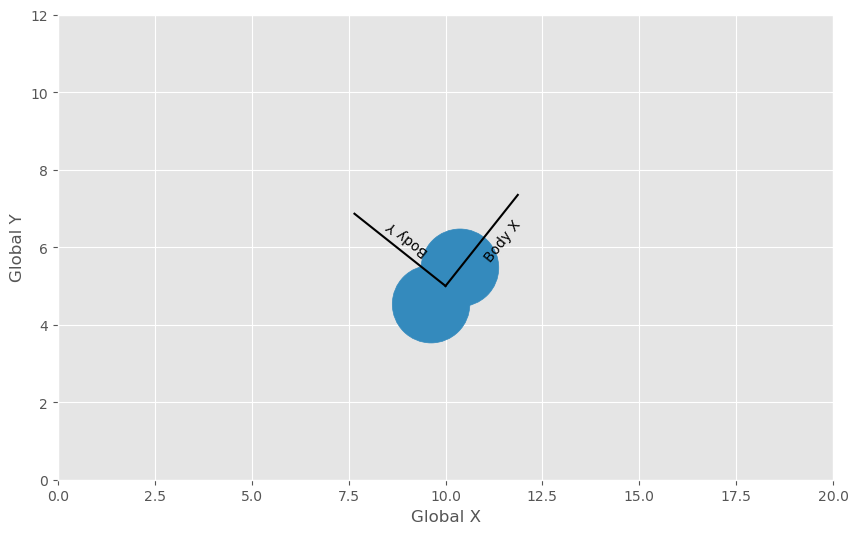

In [139]:
fig = matplotlib.figure.Figure(figsize=(10, 6.18), dpi=100)
ax = fig.add_subplot(aspect='equal')

ax.plot([central_position[0], central_position[0] - 3 * sin_theta],
        [central_position[1], central_position[1] + 3 * cos_theta],
        color='k')

ax.plot([central_position[0], central_position[0] + 3 * cos_theta],
        [central_position[1], central_position[1] + 3 * sin_theta],
        color='k')

ax.text(central_position[0] + 1.5 * cos_theta,
        central_position[1] + 1.5 * sin_theta,
        'Body X',
        rotation=central_rotation * 180 / math.pi,
        verticalalignment='center')

ax.text(central_position[0] - 2 * sin_theta,
        central_position[1] + 2 * cos_theta,
        'Body Y',
        rotation=central_rotation * 180 / math.pi + 90,
        verticalalignment='center')

ax.add_patch(
    matplotlib.patches.Circle((central_position[0], central_position[1]),
                              0.1,
                              color='C0'))

for position in global_positions:
    ax.add_patch(
        matplotlib.patches.Circle((position[0], position[1]), 1.0, color='C1'))

ax.set_xlim(0, 20)
ax.set_ylim(0, 12)

ax.set_xlabel('Global X')
ax.set_ylabel('Global Y')

fig

In [140]:
snapshot = gsd.hoomd.Snapshot()
snapshot.particles.types = ['dimer', 'A']

/home/marjanalbooyeh/mambaforge/envs/LJ-ML/lib/python3.11/site-packages/gsd/hoomd.py:420: FutureWarning: Snapshot is deprecated, use Frame
  warnings.warn("Snapshot is deprecated, use Frame", FutureWarning)


In [141]:
N_particles = 2
spacing = 5
K = math.ceil(N_particles**(1 / 3))
L = K * spacing
x = numpy.linspace(-L / 2, L / 2, K, endpoint=False)
position = list(itertools.product(x, repeat=3))
position = numpy.array(position) + [spacing / 2, spacing / 2, spacing / 2]
snapshot.particles.N = N_particles
snapshot.particles.position = position[0:N_particles, :]
snapshot.particles.typeid = [0] * N_particles
snapshot.configuration.box = [L, L, L, 0, 0, 0]

In [142]:
snapshot.particles.mass = [2] * N_particles

In [143]:
mass = 1
I = numpy.zeros(shape=(3, 3))
for r in dimer_positions:
    I += mass * (numpy.dot(r, r) * numpy.identity(3) - numpy.outer(r, r))
I

array([[0.  , 0.  , 0.  ],
       [0.  , 0.72, 0.  ],
       [0.  , 0.  , 0.72]])

In [144]:

snapshot.particles.moment_inertia = [I[0, 0], I[1, 1], I[2, 2]] * N_particles

In [145]:
snapshot.particles.orientation = [(1, 0, 0, 0)] * N_particles

In [146]:
snapshot.particles.position = [[-2.5, -2.5, -1, -2.5, -2.5, 1]]


In [147]:
with gsd.hoomd.open(name='dimer_centers.gsd', mode='wb') as f:
    f.append(snapshot)

/home/marjanalbooyeh/mambaforge/envs/LJ-ML/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'wb' mode is deprecated, use 'w'
  gsdfileobj = fl.open(name=str(name),


In [148]:
rigid = hoomd.md.constrain.Rigid()
rigid.body['dimer'] = {
    "constituent_types": ['A', 'A'],
    "positions": dimer_positions,
    "orientations": [(1.0, 0.0, 0.0, 0.0), (1.0, 0.0, 0.0, 0.0)],
    "charges": [0.0, 0.0],
    "diameters": [1., 1.]
}

/home/marjanalbooyeh/mambaforge/envs/LJ-ML/lib/python3.11/site-packages/hoomd/md/constrain.py:44: FutureWarning: The charges key is deprecated and will be removed in hoomd 4.0.
  warnings.warn(msg, FutureWarning)
/home/marjanalbooyeh/mambaforge/envs/LJ-ML/lib/python3.11/site-packages/hoomd/md/constrain.py:44: FutureWarning: The diameters key is deprecated and will be removed in hoomd 4.0.
  warnings.warn(msg, FutureWarning)


In [149]:
sim = hoomd.Simulation(device=hoomd.device.GPU(), seed=4)
sim.create_state_from_gsd(filename='dimer_centers.gsd')

In [150]:
rigid.create_bodies(sim.state)

In [151]:
hoomd.write.GSD.write(state=sim.state, mode='wb', filename='lattice.gsd')

## Part2 : Run rigid body simulation

In [2]:
dimer_positions = [[-0.6, 0, 0], [0.6, 0, 0]]

In [3]:

gpu = hoomd.device.GPU()
sim = hoomd.Simulation(device=gpu, seed=1)
sim.create_state_from_gsd(filename='lattice.gsd')

In [4]:

rigid = hoomd.md.constrain.Rigid()

In [5]:
rigid.body['dimer'] = {
    "constituent_types": ['A', 'A'],
    "positions": dimer_positions,
    "orientations": [(1.0, 0.0, 0.0, 0.0), (1.0, 0.0, 0.0, 0.0)],
    "charges": [0.0, 0.0],
    "diameters": [1., 1.]
}

/home/marjanalbooyeh/mambaforge/envs/LJ-ML/lib/python3.11/site-packages/hoomd/md/constrain.py:44: FutureWarning: The charges key is deprecated and will be removed in hoomd 4.0.
  warnings.warn(msg, FutureWarning)
/home/marjanalbooyeh/mambaforge/envs/LJ-ML/lib/python3.11/site-packages/hoomd/md/constrain.py:44: FutureWarning: The diameters key is deprecated and will be removed in hoomd 4.0.
  warnings.warn(msg, FutureWarning)


In [6]:
integrator = hoomd.md.Integrator(dt=0.005, integrate_rotational_dof=True)
sim.operations.integrator = integrator

In [7]:

integrator.rigid = rigid

In [8]:
kT = 1.5
rigid_centers_and_free = hoomd.filter.Rigid(("center", "free"))
nvt = hoomd.md.methods.NVT(kT=kT, tau=1., filter=rigid_centers_and_free)
integrator.methods.append(nvt)
# cap = hoomd.md.methods.DisplacementCapped(filter=rigid_centers_and_free, maximum_displacement=1e-2)
# integrator.methods.append(cap)

/home/marjanalbooyeh/mambaforge/envs/LJ-ML/lib/python3.11/site-packages/hoomd/md/methods/methods.py:102: FutureWarning: NVT is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method with the desired thermostat from hoomd.md.methods.thermostats.
  warnings.warn(


In [9]:
cell = hoomd.md.nlist.Cell(buffer=0, exclusions=['body'])

In [10]:
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 2.5

lj.params[('dimer', ['dimer', 'A'])] = dict(epsilon=0, sigma=0)
lj.r_cut[('dimer', ['dimer', 'A'])] = 0

In [11]:
integrator.forces.append(lj)

In [12]:
thermodynamic_quantities = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())

sim.operations.computes.append(thermodynamic_quantities)

In [13]:
sim.state.thermalize_particle_momenta(filter=rigid_centers_and_free, kT=kT)
sim.run(0)


In [14]:
nvt.thermalize_thermostat_dof()

In [15]:
sim.state.box

hoomd.box.Box(Lx=10.0, Ly=10.0, Lz=10.0, xy=0.0, xz=0.0, yz=0.0)

#### Shrink the box

In [16]:
initial_box = sim.state.box
final_box = hoomd.Box.from_box(initial_box)  # make a copy of initial_box
final_box.volume = initial_box.volume / 7
box_resize_trigger = hoomd.trigger.Periodic(10)
ramp = hoomd.variant.Ramp(A=0, B=1, t_start=sim.timestep, t_ramp=20000)
box_resize = hoomd.update.BoxResize(box1=initial_box,
                                    box2=final_box,
                                    variant=ramp,
                                    trigger=box_resize_trigger)
sim.operations.updaters.append(box_resize)

In [17]:
sim.run(30000)

In [18]:
sim.state.box

hoomd.box.Box(Lx=5.227579585747102, Ly=5.227579585747102, Lz=5.227579585747102, xy=0.0, xz=0.0, yz=0.0)

In [19]:
thermodynamic_quantities.translational_kinetic_energy

2.7366191894907135

In [20]:
thermodynamic_quantities.rotational_kinetic_energy

4.106848669693349

In [21]:
sim.operations.updaters.clear()

### shrinking is done, let's log properties.

In [22]:
import os
if not os.path.exists("dimer_init_data"):
    os.mkdir("dimer_init_data")

In [23]:
import h5py
import numpy as np
class RigidDataWriter(hoomd.custom.Action):
    def __init__(self, filename, mode, N_rigids):
        self.filename = filename
        self.N_rigids = N_rigids
        self.properties = ['position', 'orientation', 'net_force', 'net_torque']
        if mode not in {'w', 'w-', 'x', 'a', 'r+'}:
            raise ValueError("mode must be writtable")
        self.file = h5py.File(filename, mode)
        self.write_metadata()
        frames = list(self.file.keys())
        if frames:
            self._cur_frame = max(map(int, frames)) + 1
        else:
            self._cur_frame = 1

    def write_metadata(self):
        """Write the file metadata that defines the type of hdf5 file"""
        if 'app' in self.file.attrs:
            if self.file.attrs.app != 'hoomd-v3':
                raise RuntimeError(
                    'HDF5 file metadata "app" is not "hoomd-v3".')
        else:
            self.file.attrs.app = 'hoomd-v3'

        if 'version' not in self.file.attrs:
            self.file.attrs.version = '1.0'

    def act(self, timestep):
        new_frame = self.file.create_group(str(self._cur_frame))
        self._cur_frame += 1
        with self._state.cpu_local_snapshot as snap:
            rtag = np.array(snap.particles.rtag, copy=True)
            for prop in self.properties:
                data = np.array(getattr(snap.particles, prop), copy=True)
                data = data[rtag][:self.N_rigids]
                dataset = new_frame.create_dataset(prop, data.shape, dtype=str(data.dtype))
                dataset[:] = data

        new_frame.attrs['timestep'] = timestep

    def __del__(self):
        self.file.close()


h5_writer = hoomd.write.CustomWriter(action=RigidDataWriter(filename="dimer_init_data/rigid_traj_v2.h5",
                                                            mode="w", N_rigids=2),
                                     trigger=int(100))


# Logging 
log_quantities = [
            "kinetic_temperature",
            "potential_energy",
            "kinetic_energy",
            "volume",
            "pressure",
            "pressure_tensor",
        ]
logger = hoomd.logging.Logger(categories=["scalar", "string", "particle"])
logger.add(sim, quantities=["timestep", "tps"])
thermo_props = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
sim.operations.computes.append(thermo_props)
logger.add(thermo_props, quantities=log_quantities)

for f in integrator.forces:
    
    logger.add(f, quantities=["energy", "forces", "energies"])

gsd_writer = hoomd.write.GSD(
    filename="dimer_init_data/traj_v2.gsd",
    trigger=hoomd.trigger.Periodic(int(100)),
    mode="wb",
    logger=logger,
    dynamic=["momentum"]
    )

sim.operations.writers.append(gsd_writer)
sim.operations.writers.append(h5_writer)


In [24]:
sim.run(500000)

In [25]:
sim.timestep

530000

In order to collect more data samples with energy >0, we manually change rigid center positions and bring them closer to eachother using capped distance integrator.

In [71]:
with sim._state.cpu_local_snapshot as data:
    rtag = data.particles.rtag
    print(data.particles.position[rtag])
    first_rigid_pos = data.particles.position[rtag][0]

[[ 1.14717759 -0.79931423 -2.15829307]
 [ 0.9306745  -0.15112745 -2.46456633]
 [ 1.55824965 -0.52503408 -1.81801354]
 [ 0.73610552 -1.07359439 -2.49857259]
 [ 0.49357891 -0.11984679 -2.05472616]
 [ 1.36777009 -0.18240811  2.35317308]]


In [72]:
second_rigid_pos = first_rigid_pos + [0.3 , 0.3, 0.3]
second_rigid_pos

array([ 1.44717759, -0.49931423, -1.85829307])

In [73]:
with sim._state.cpu_local_snapshot as data:
    second_rigid_idx = data.particles.rtag[1]
    data.particles.position[second_rigid_idx] = second_rigid_pos
    

In [74]:
sim.run(0)

In [75]:
with sim._state.cpu_local_snapshot as data:
    rtag = data.particles.rtag
    print(data.particles.position[rtag])

[[ 1.14717759 -0.79931423 -2.15829307]
 [ 1.44717759 -0.49931423 -1.85829307]
 [ 1.55824965 -0.52503408 -1.81801354]
 [ 0.73610552 -1.07359439 -2.49857259]
 [ 1.010082   -0.46803357 -1.4484529 ]
 [ 1.88427318 -0.53059489 -2.26813324]]


In [76]:
#remove nvt integrator
integrator.methods.clear()

In [77]:
cap = hoomd.md.methods.DisplacementCapped(filter=rigid_centers_and_free, maximum_displacement=1e-3)
integrator.methods.append(cap)


In [78]:
sim.run(60000)

In [79]:
with sim._state.cpu_local_snapshot as data:
    rtag = data.particles.rtag
    print(data.particles.position[rtag])

[[ 1.5119932  -1.04241452  2.32834842]
 [ 1.08236197 -0.25621395 -1.11735497]
 [ 1.22591914 -0.92856333 -2.38425589]
 [ 1.79806726 -1.1562657   1.81337314]
 [ 1.19691364 -0.4242378  -1.68184225]
 [ 0.9678103  -0.08819009 -0.55286768]]


In [211]:
h5_writer.file.flush()

In [212]:
h5_writer.file.close()

## Part 3: Collect data after finishing simulation (preparing ML datasets)

In [213]:
import pandas as pd
import h5py
import numpy as np
f = h5py.File("dimer_init_data/rigid_traj_v2.h5", 'r')
traj_df = pd.DataFrame()
for i, frame in enumerate(f.keys()):
    if i % 10000 == 0:
        print(i)
    dset = dict(f[frame])
    dset = {key: np.array(value) for key, value in dset.items()}
    dset['timestep'] = f[frame].attrs['timestep']
    traj_df = pd.concat([traj_df,pd.DataFrame([dset])], ignore_index=True)

f.close()


positions = np.asarray(traj_df["position"].tolist())
orientations = np.asarray(traj_df["orientation"].tolist())
net_force = np.asarray(traj_df["net_force"].tolist())
net_torque = np.asarray(traj_df['net_torque'].tolist())

0


In [214]:
import rowan

In [215]:
import gsd.hoomd

traj = gsd.hoomd.open("dimer_init_data/traj_v2.gsd")

In [216]:
box_len = traj[0].configuration.box[0] / 2.

In [217]:
box_len

2.6137897968292236

In [35]:
def check_boundary(x, l):
    if x > l:
        return x - l
    elif x < -l:
        return x + l
    return x
    

In [219]:
rel_positions = []
rel_orientations = []
forces = []
torques = []
for pos, orient, force, torque in zip(positions, orientations, net_force, net_torque):
    dx, dy, dz = pos[0] - pos[1]
    dx = check_boundary(dx, box_len)
    dy = check_boundary(dy, box_len)
    dz = check_boundary(dz, box_len)
    rel_positions.append([dx, dy, dz])
    rel_positions.append([-dx, -dy, -dz])
    rel_orientations.append(rowan.multiply(orient[1], rowan.conjugate(orient[0])))
    rel_orientations.append(rowan.multiply(orient[0],rowan.conjugate(orient[1])))
    forces.append(force[0])
    forces.append(force[1])
    torques.append(torque[0])
    torques.append(torque[1])

In [220]:
columns = [
    "position",
    "orientation",
    "net_force",
    "net_torque",
]

In [221]:
new_traj_df = pd.DataFrame(columns=columns)
new_traj_df["position"] = rel_positions
new_traj_df["orientation"] = rel_orientations
new_traj_df["net_force"] = forces
new_traj_df["net_torque"] = torques

In [222]:
import os
target_datapath = "/home/erjank_project/caesreu/datasets/dimer/"
if not os.path.exists(target_datapath):
    os.mkdir(target_datapath)

In [223]:
new_traj_df.to_pickle(os.path.join(target_datapath, "raw.pkl"))

In [226]:
new_traj_df.shape

(11000, 4)

In [224]:
new_traj_df = new_traj_df.sample(frac=1).reset_index(drop=True)

test_frac = 0.1
val_frac = 0.1

dataset_len = new_traj_df.shape[0]
test_len = int(dataset_len * test_frac)
val_len = int(dataset_len * val_frac)

test_df = new_traj_df.loc[:test_len]

val_df = new_traj_df.loc[test_len: test_len + val_len]

train_df = new_traj_df.loc[test_len + val_len:]


In [225]:
train_df.to_pickle(os.path.join(target_datapath, 'train.pkl'))
val_df.to_pickle(os.path.join(target_datapath, 'val.pkl'))
test_df.to_pickle(os.path.join(target_datapath, 'test.pkl'))

### Analyzing the data

In [80]:
import gsd.hoomd

In [81]:
gsd_traj = gsd.hoomd.open("dimer_init_data/traj_v2.gsd", "rb")

In [82]:
gsd_traj[0].log.keys()

dict_keys(['Simulation/timestep', 'Simulation/tps', 'md/compute/ThermodynamicQuantities/kinetic_temperature', 'md/compute/ThermodynamicQuantities/potential_energy', 'md/compute/ThermodynamicQuantities/kinetic_energy', 'md/compute/ThermodynamicQuantities/volume', 'md/compute/ThermodynamicQuantities/pressure', 'md/pair/LJ/energy', 'particles/md/pair/LJ/forces', 'particles/md/pair/LJ/energies'])

In [83]:
len(gsd_traj)

6200

In [84]:
import numpy as np
import rowan

In [85]:
box_len = gsd_traj[-1].configuration.box[0] / 2.
box_len

2.6137897968292236

In [86]:
positions_1 = []
orient_dis = []
r_1 = []
energies_1 = []

for frame in gsd_traj:
    pos = frame.particles.position
    orient = frame.particles.orientation
    positions_1.append(pos)
    dx, dy, dz = pos[0] - pos[1]
    dx = check_boundary(dx, box_len)
    dy = check_boundary(dy, box_len)
    dz = check_boundary(dz, box_len)
    r_1.append(np.linalg.norm([dx, dy, dz]))
    orient_dis.append(rowan.geometry.distance(orient[0], orient[1]))
    energies_1.append(frame.log['md/pair/LJ/energy'])


In [65]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'COM Energies')

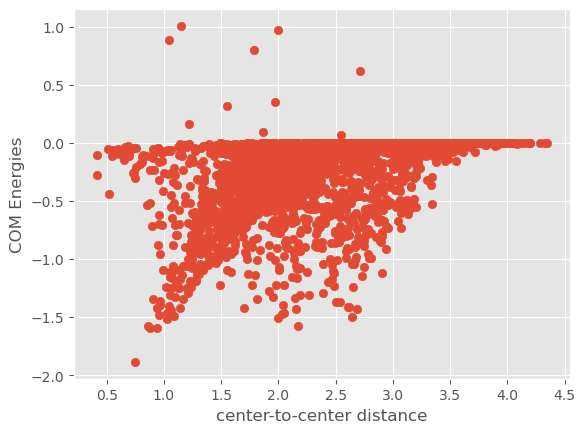

In [42]:
plt.scatter(r_1, np.asarray(energies_1)/2)
plt.xlabel("center-to-center distance")
plt.ylabel("COM Energies")

In [87]:
len(energies_1)

6200

In [88]:
energies_1 = np.asarray(energies_1)

In [89]:
min(energies_1)

array([-3.99653689])

In [90]:
max(energies_1)

array([1709411.70185598])

In [91]:
np.where(energies_1>0)[0].shape[0] / energies_1.shape[0]

0.005967741935483871

In [92]:
energies_1.shape

(6200, 1)

### trying to make sense of data with Gay-Berne distance

In [167]:
import rowan
import torch
def GB_compute(dr, lperp, lpar, qi, qj):
    lperp = torch.tensor(lperp).unsqueeze(dim=0)
    lpar = torch.tensor(lpar).unsqueeze(dim=0)
    dr = torch.from_numpy(dr).unsqueeze(dim=0)
    r_norm = torch.norm(dr, dim=-1)
    unit_r = torch.einsum('ij, i -> ij', dr, 1/r_norm).to(torch.float32)

    dr_dot =torch.einsum('ij, ij -> i', dr, dr)

    
    rot_A = rowan.to_matrix(rowan.conjugate(qi))
    rot_B =  rowan.to_matrix(rowan.conjugate(qj))

    a3 = torch.from_numpy(rot_A[:, 2]).unsqueeze(dim=0).to(torch.float32)
    b3 = torch.from_numpy(rot_B[:, 2]).unsqueeze(dim=0).to(torch.float32)

    ca=torch.einsum('ij, ij -> i', a3, unit_r )
    cb=torch.einsum('ij, ij -> i', b3, unit_r )
    cab=torch.einsum('ij, ij -> i', a3, b3 )

    chi = (lpar**2 - lperp**2) / (lpar**2 + lperp**2)
    chic = chi*cab

    chi_fact = chi/(1-chic**2)
    r_fact = (r_norm/(2*lperp**2))
    par1 = torch.einsum('i, ij ->ij ', (ca-chic*cb), a3)
    par2 = torch.einsum('i, ij ->ij ', (cb-chic*ca), b3)
    inner_fact = par1 + par2


    kappa = torch.einsum('i, ij ->ij', r_fact, (unit_r-torch.einsum('i, ij ->ij', chi_fact,inner_fact)))

    phi = (1/2) * torch.einsum('ij, ij -> i', dr, kappa) / dr_dot


    sigma = 1/torch.sqrt(phi)


    sigma_min = 2*torch.min(torch.stack((lperp, lpar), dim=-1), dim=-1)[0]
    sigma_max = 2*torch.max(torch.stack((lperp, lpar), dim=-1), dim=-1)[0]

    zeta = (r_norm - sigma + sigma_min) / sigma_min
    return zeta

In [169]:
dists = []
orients = []

energies = []

for frame in gsd_traj:
    pos = frame.particles.position
    orients.append(frame.particles.orientation[:2])
    dx, dy, dz = pos[0] - pos[1]
    dx = check_boundary(dx, box_len)
    dy = check_boundary(dy, box_len)
    dz = check_boundary(dz, box_len)
    dists.append(np.array([dx, dy, dz]))
    energies.append(frame.log['md/pair/LJ/energy'])


In [168]:
frame.particles.orientation

array([[-0.7280176 , -0.4852165 ,  0.35743287,  0.32679817],
       [ 0.71418107,  0.5043004 ,  0.43180066,  0.22175361],
       [-0.7280176 , -0.4852165 ,  0.35743287,  0.32679817],
       [-0.7280176 , -0.4852165 ,  0.35743287,  0.32679817],
       [ 0.71418107,  0.5043004 ,  0.43180066,  0.22175361],
       [ 0.71418107,  0.5043004 ,  0.43180066,  0.22175361]],
      dtype=float32)

In [170]:
gb_dist = []
for dr, ori in zip(dists, orients):
    gb_dist.append(GB_compute(dr, lperp=1, lpar=2.2, qi=ori[0], qj=ori[1]).item())

In [173]:
gb_dist

[0.616293722758438,
 0.387572088639503,
 0.8774644136428833,
 0.9559428691864014,
 0.7163451910018921,
 1.012283205986023,
 1.4795509576797485,
 1.0683842897415161,
 0.8841855525970459,
 0.5116630792617798,
 1.0203505754470825,
 1.2044363021850586,
 0.9279711246490479,
 0.45097869634628296,
 0.1168680191040039,
 0.5736730694770813,
 0.6785297989845276,
 0.6894955635070801,
 0.8630417585372925,
 1.0877156257629395,
 0.9456881284713745,
 0.9184277057647705,
 1.5577143430709839,
 1.6447941064834595,
 1.043586434611421,
 1.1705152063150168,
 0.7650448801583195,
 0.30459684716757673,
 0.5512691899266979,
 1.0862904970220484,
 1.5577517450987415,
 1.3669843517235298,
 0.6153123117339783,
 0.4753361646360812,
 0.06047255393425077,
 1.0559861660003662,
 -0.024112939834594727,
 0.731060266494751,
 1.1246846914291382,
 1.0762722701507723,
 1.0071738515918098,
 1.2006983544149248,
 1.2913202078782473,
 0.9704332616099713,
 1.2710546255111694,
 0.997205376625061,
 0.7167773246765137,
 1.0054383277

Text(0, 0.5, 'Energies')

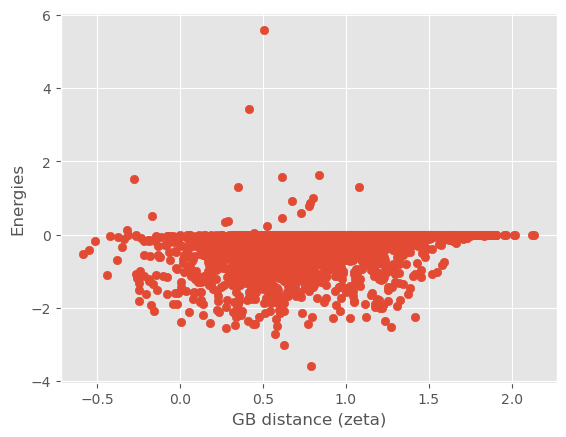

In [174]:
import matplotlib.pyplot as plt
plt.scatter(gb_dist, energies)
plt.xlabel("GB distance (zeta)")
plt.ylabel("Energies")